<h2>Semantic Segmentation　（教師付きセグメンテーション）</h2>

 →入力画像の各ピクセルに対して適切なラべル付けを行う


<h3>使うデータセット</h3>
・心臓のMRI画像と，対応するラベル付け


・いずれも256*256画素。


・前者は0~255のint型(グレースケール)，後者は0 or 1の2値ラベル


・データ数は合計282個。訓練データ256, テストデータ26で以下の実験をした。

In [0]:
!curl https://colab.chainer.org/install | sh -
!apt-get install -y graphviz
!python -c 'import chainer; chainer.print_runtime_info()'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  21351      0 --:--:-- --:--:-- --:--:-- 21351
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 

In [0]:
!pip install chainercv matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import glob
import cupy
import chainercv
import matplotlib
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import iterators, optimizers, training, datasets
from chainer.datasets import split_dataset_random
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu
from chainer.training import extensions
import numpy as np

import os
import xml.etree.ElementTree as ET
from chainercv.datasets import VOCBboxDataset
from chainercv.visualizations import vis_bbox
from chainercv.links import SSD300
from chainercv.links.model.ssd import multibox_loss

from IPython.display import Image
from PIL import Image
from chainer import reporter
from chainer import cuda
from chainercv import evaluations

In [0]:
!if [ ! -d train ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/train.zip && unzip train.zip && rm -rf train.zip; fi
!if [ ! -d val ]; then curl -L -O https://github.com/mitmul/chainer-handson/releases/download/SegmentationDataset/val.zip && unzip val.zip && rm -rf val.zip; fi

<h3>　具体的なデータ例 </h3>

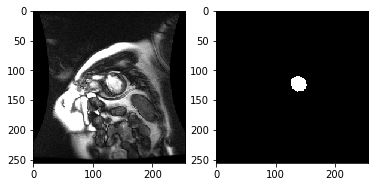

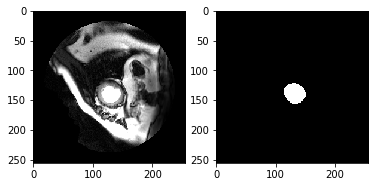

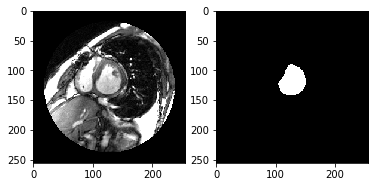

In [0]:
for i in range(3):
  img = np.asarray(Image.open("train/image/00"+str(i)+".png"))
  label = np.asarray(Image.open("train/label/00"+str(i)+".png"))
  fig, axes = plt.subplots(1,2)
  axes[0].imshow(img, cmap="gray")
  axes[1].imshow(label, cmap="gray")
  plt.show()

In [0]:
def create_dataset(img_files, label_files):
  img = datasets.ImageDataset(img_files)
  img = datasets.TransformDataset(img, lambda x: x/255.)
  label = datasets.ImageDataset(label_files, dtype = np.int32)
  dataset = datasets.TupleDataset(img, label)
  return dataset  


def create_datasets():
  train_img_files   = sorted(glob.glob("train/image/*.png"))
  train_label_files = sorted(glob.glob("train/label/*.png"))  
  train = create_dataset(train_img_files, train_label_files)
  val_img_filenames = sorted(glob.glob('val/image/*.png'))
  val_label_filenames = sorted(glob.glob('val/label/*.png'))
  val = create_dataset(val_img_filenames, val_label_filenames)
  return train, val

In [0]:
train, val = create_datasets()

FIXME_1 = 32
FIXME_2 = 64
FIXME_3 = 64
FIXME_4 = 128
FIXME_5 = 128

In [0]:
def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
        
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])

    
    
def show_predicts(trainer, val, device=-1, n_sample=len(val)):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        fig, axes = plt.subplots(1, 2)

        axes[0].set_axis_off()
        axes[0].imshow(pred, cmap='gray')

        axes[1].set_axis_off()
        axes[1].imshow(label[0], cmap='gray')

        plt.show()

In [0]:
class PixelwiseSigmoidClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)

        # 2クラス分類の誤差を計算
        loss = F.sigmoid_cross_entropy(y, t)

        # 予測結果（0~1の連続値を持つグレースケール画像）を二値化し，
        # ChainerCVのeval_semantic_segmentation関数に正解ラベルと
        # 共に渡して各種スコアを計算
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        # 学習中のログに出力
        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

In [0]:
def my_trainer(model, batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer

## モデル➀


・U_Netの論文を読み，類似のネットワークを構成した


・低解像度の特徴量マップと，高解像度の(位置情報に役立つ)マップをconcatした。


・特徴量抽出の次元を32*32にまで落とした。

<img src="IMG_1699.jpg">

In [0]:
class U_Net(chainer.Chain):
  def __init__(self, n_class=1):
    super().__init__()
    with self.init_scope():
      self.conv1 = L.Convolution2D(None, FIXME_1, ksize=3, stride=1, pad=1)  #(batch_size, FIXME_1, height, width)
      self.conv2 = L.Convolution2D(None, FIXME_1, ksize=3, stride=1, pad=1)
      self.conv3 = L.Convolution2D(None, FIXME_2, ksize=3, stride=1, pad=1)
      self.conv4 = L.Convolution2D(None, FIXME_2, ksize=3, stride=1, pad=1)
      self.conv5 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)
      self.conv6 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)     
      
      self.deconv1 = L.Deconvolution2D(None, FIXME_2, ksize=2, stride=2, pad=0)      
      self.deconv2 = L.Deconvolution2D(None, FIXME_1, ksize=2, stride=2, pad=0)      
   
      self.conv7 = L.Convolution2D(None, FIXME_2, ksize=3, stride=1, pad=1)      
      self.conv8 = L.Convolution2D(None, FIXME_2, ksize=3, stride=1, pad=1)      
      self.conv9 = L.Convolution2D(None, FIXME_1, ksize=3, stride=1, pad=1)      
      self.conv10 = L.Convolution2D(None, FIXME_1, ksize=3, stride=1, pad=1)      
      self.conv11 = L.Convolution2D(None, n_class , ksize=1, stride=1, pad=0)     
      
      #もう1段階追加するために，以下を追加した
      self.conv_a = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)
      self.conv_b = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)   
      self.deconv_c = L.Deconvolution2D(None, FIXME_3, ksize=2, stride=2, pad=0)            
      self.conv_d = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)      
      self.conv_e = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)
      
      
  def forward(self, x):
      h = F.relu(self.conv1(x))
      h1 = F.relu(self.conv2(h))
      h = F.max_pooling_2d(h1, 2, 2)  #(batch_size, FIXME_1, height/2, width/2)
      
      #print(h.shape)
      
      h = F.relu(self.conv3(h))   #(batch_size, FIXME_2, 128, 128)
      h2 = F.relu(self.conv4(h))
      h = F.max_pooling_2d(h2, 2, 2)  #(batch_size, FIXME_2, 64, 64)
      
      #print(h.shape)
      
      h = F.relu(self.conv5(h))   #(batch_size, FIXME_3, 64, 64)
      h3 = F.relu(self.conv6(h))
      
      #以下を追加した
      h = F.max_pooling_2d(h3, 2, 2) 
      h = F.relu(self.conv_a(h))   
      h = F.relu(self.conv_b(h))    
      h = self.deconv_c(h) 
      h = F.concat((h3,h), axis=1)
      h = F.relu(self.conv_d(h))   
      h = F.relu(self.conv_e(h))          
      #以上を追加した
      
      
      #expansive path
      h = self.deconv1(h)  #(batch_size, FIXME_2, 128, 128)
      h = F.concat((h2,h), axis=1)  #(batch_size, 256, 128, 128)
      
      #print(h.shape)
      
      h = F.relu(self.conv7(h))  #(batch, 128, 128, 128)
      h = F.relu(self.conv8(h))  #(batch, 128, 128, 128)      
      h = self.deconv2(h)  #(batch, 64, 256, 256)
      h = F.concat((h1, h), axis=1)  #(batch, 128, 256, 256)
      
      #print(h.shape)
      
      h = F.relu(self.conv9(h))   #(batch, 64, 256, 256)
      h = F.relu(self.conv10(h))  
      h = F.relu(self.conv11(h))  #(batch, 1 , 256, 256)
      
      #print(h.shape)
      
      return h  

<h3>・200エポック


・ミニバッチのサイズ=32


・学習データ256より，1epoch当たりのバッチ数8 

In [0]:
%%time
trainer = my_trainer(U_Net(), 32, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.693147    0.491963    0.983926    0.693147       0.491152       0.982304     
20          0.693147    0.491848    0.983696    0.693147       0.491152       0.982304     
30          0.693147    0.491811    0.983623    0.693147       0.491152       0.982304     
40          0.693147    0.49187     0.98374     0.693147       0.491152       0.982304     
50          0.693147    0.491719    0.983438    0.693147       0.491152       0.982304     
60          0.693147    0.490413    0.980826    0.693147       0.491152       0.982304     
70          0.693147    0.49074     0.981479    0.693147       0.491152       0.982304     
80          0.693147    0.491063    0.982125    0.693147       0.491152       0.982304     
90          0.693147    0.492462    0.984923    0.693147       0.491152       0.982304     
100         0.693147    0.492079    0.984158    0.693147       0.491152       0.98

###  lossが変わらず一定
###  左が推論結果，右は正解。
### どの入力に対しても同じ出力となってしまった

Pixel Accuracy: 0.9823044996995193
mIoU: 0.49115224984975964


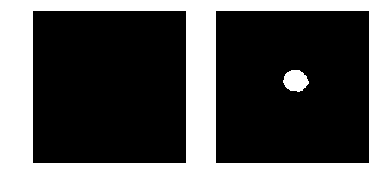

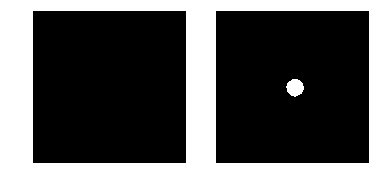

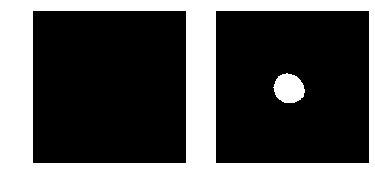

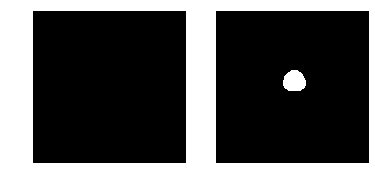

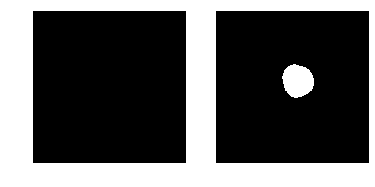

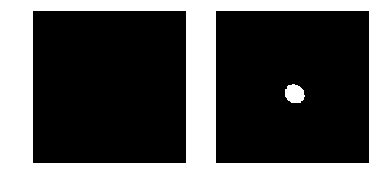

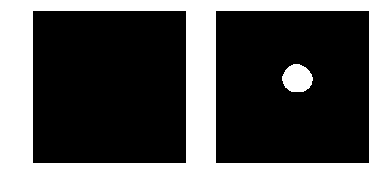

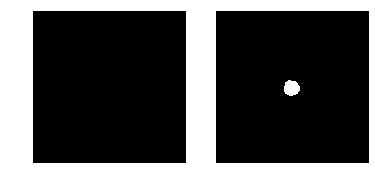

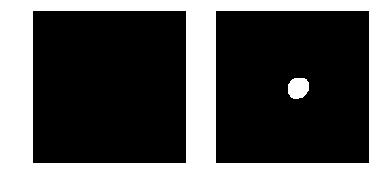

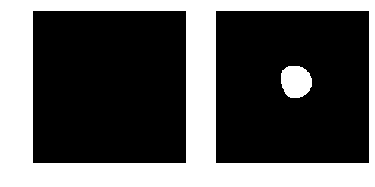

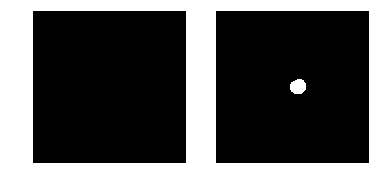

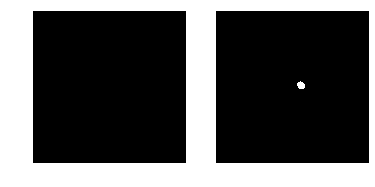

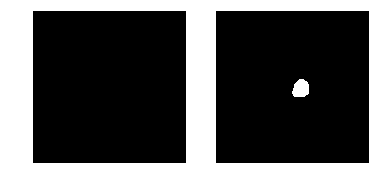

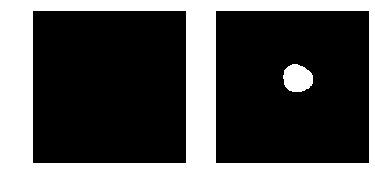

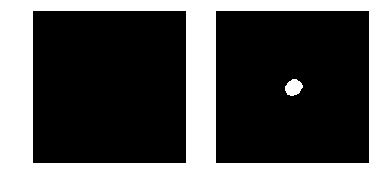

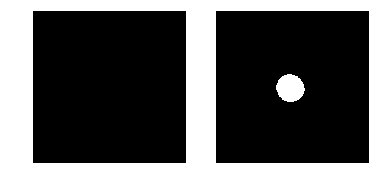

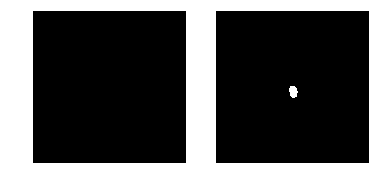

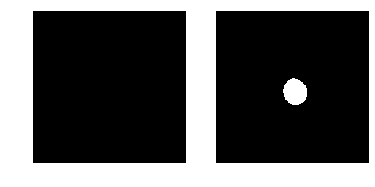

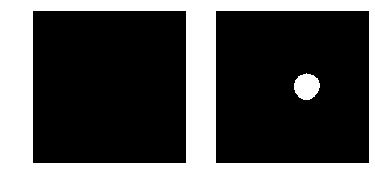

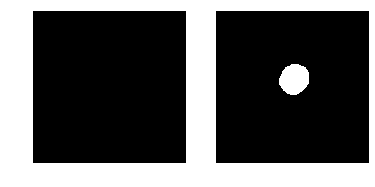

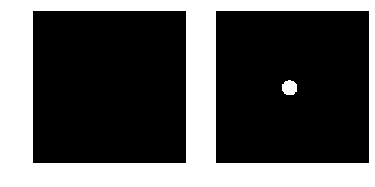

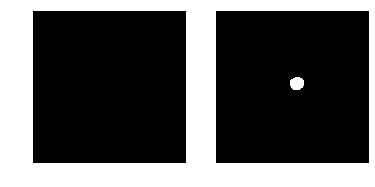

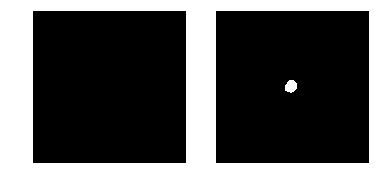

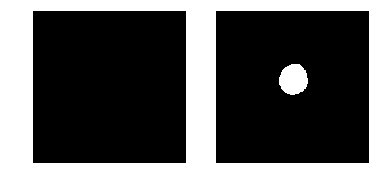

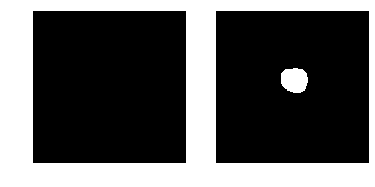

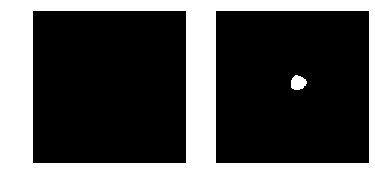

In [0]:
evaluate(trainer, val, device=0)
show_predicts(trainer, val, device=0, )

### 考察

・そもそも，クラス間 imbalanceがある(黒98%, 白2%くらい)ため，それを考慮し，loss関数をいじったほうがよさそう

→しかし残念ながら、IoUは、損失関数に不向きな事が式の形からわかる。

→ 最近の研究だと、lovasz softmax などが有力か


・loss関数はsigmoid_cross_entropyであるため，この学習結果のloss自体はたしかに，高い訳ではない。すなわち，学習データ数に対して，パラメタが多すぎるため，局所解に陥った可能性が考えられる。

→使う層の数を減らし，かつ，積極的に次元を下げていったらどうなるか？



## そこで，モデル②


・基本的なアーキテクチュアはU_Netと似ているが，層数を大幅に減らした

（特にexpansive path, すなわちdecoderの部分）


・特徴量抽出の次元は16 * 16


・skip connection の部分について，

　　concat, residual,そもそも無し，の3パターンを試した。

<img src="IMG_1700.jpg">

In [0]:
class U_Net_Modified(chainer.Chain):
    def __init__(self, n_class=1, residual=False, u_net=True):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)  #shape will be half 
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)  #shape will be half
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)  #not change shape 
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)  #not change shape             
            self.conv5 = L.Convolution2D(None, FIXME_1, ksize=5, stride=1, pad=2)  #not change shape
            
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, FIXME_1, ksize=16, stride=8, pad=4)
            self.deconv7 = L.Deconvolution2D(None, n_class, ksize=2 , stride=2, pad=0)
     
        self.residual = residual
        self.u_net = u_net

    def forward(self, x):
        h1 = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h1, 2, 2)
        
        #print(h.shape)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        #print(h.shape)
        
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
      

        #print(h.shape)        
        
        h = self.deconv6(h)
        
        if self.u_net:
          #residual or concat
          if self.residual:
            h = h + h1
          else:
            h = F.concat((h,h1), axis=1)

        #print(h.shape)        
        
        h = F.relu(self.conv5(h))
        h = self.deconv7(h)        

        #print(h.shape)
        
        return h

In [0]:
%%time
trainer = my_trainer(U_Net_Modified(), 32, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.0391073   0.52683     0.986184    0.04181        0.501727       0.98267      
20          0.0206974   0.503896    0.984374    0.0222926      0.507351       0.982698     
30          0.0102971   0.887254    0.995773    0.0148722      0.860003       0.993649     
40          0.00496249  0.943732    0.99805     0.00942614     0.902827       0.996199     
50          0.00403866  0.951678    0.998322    0.00859004     0.911234       0.996696     
60          0.00387367  0.95061     0.998246    0.00977102     0.912131       0.996527     
70          0.00214973  0.972352    0.99914     0.0099491      0.916104       0.996789     
80          0.00200722  0.976505    0.999205    0.00999745     0.917611       0.99694      
90          0.00165464  0.97719     0.999304    0.0099199      0.922951       0.997118     
100         0.00168355  0.98231     0.999326    0.0110782      0.920557       0.99

Loss


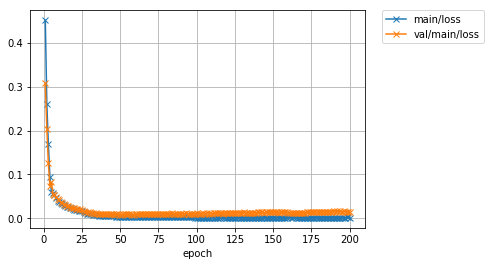

In [0]:
from IPython.display import Image

print('Loss')
Image('result_fcn/loss.png')

mean IoU


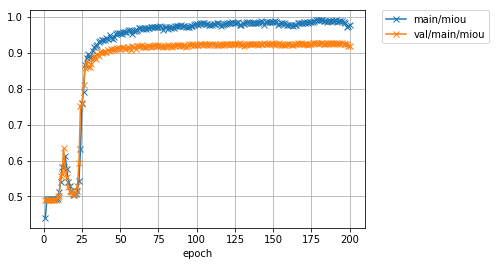

In [0]:
print('mean IoU')
Image('result_fcn/miou.png')

Pixel Accuracy


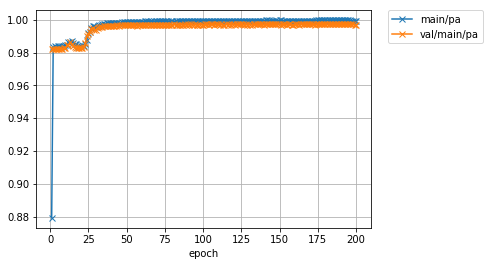

In [0]:
print('Pixel Accuracy')
Image('result_fcn/pa.png')

Pixel Accuracy: 0.996917724609375
mIoU: 0.9198643041707664


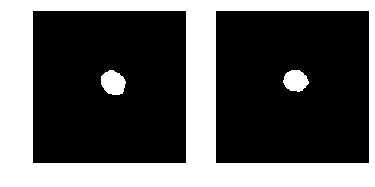

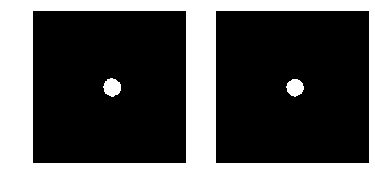

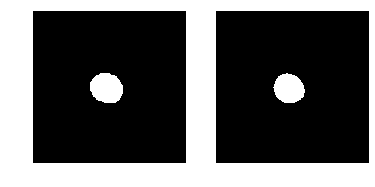

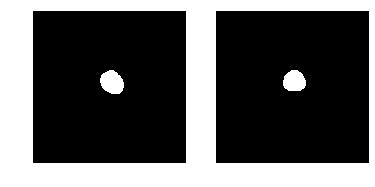

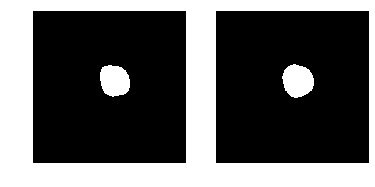

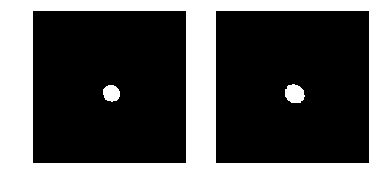

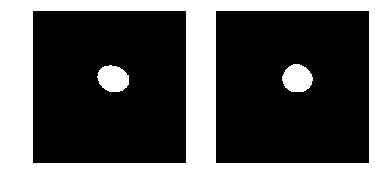

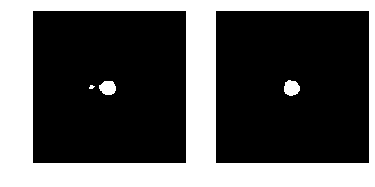

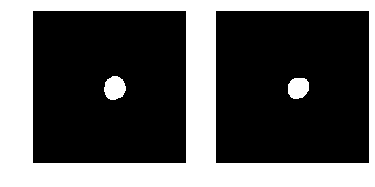

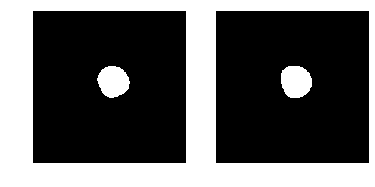

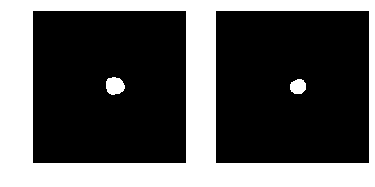

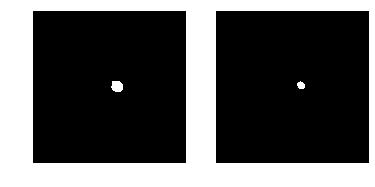

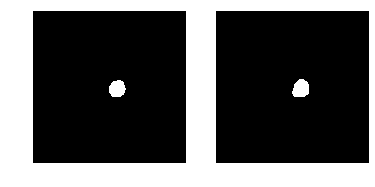

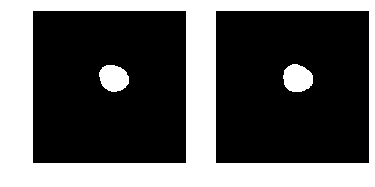

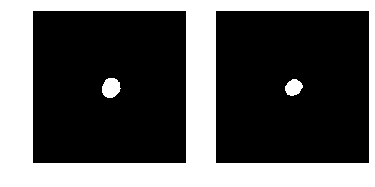

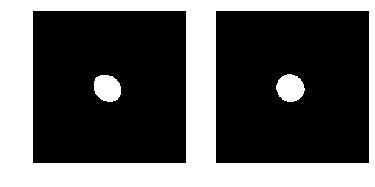

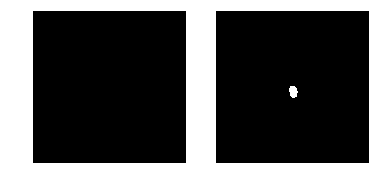

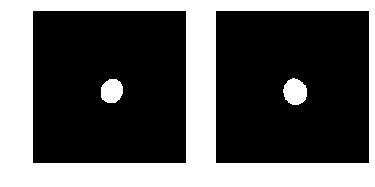

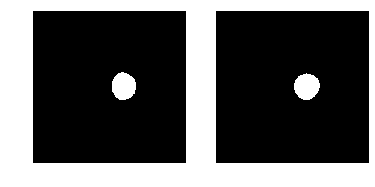

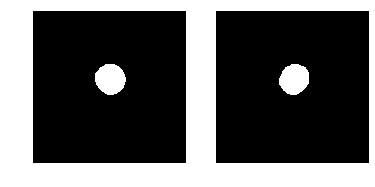

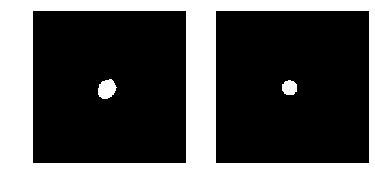

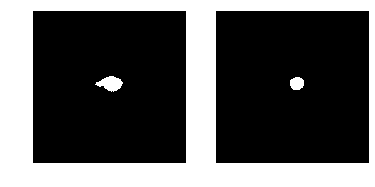

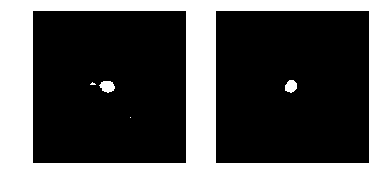

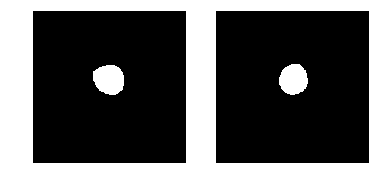

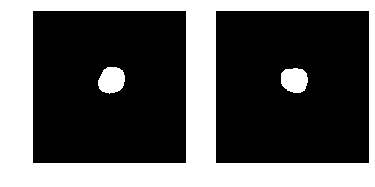

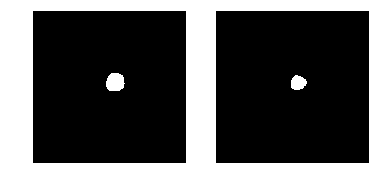

In [0]:
evaluate(trainer, val, device=0)
show_predicts(trainer, val, device=0, )

In [0]:
%%time
trainer = my_trainer(U_Net_Modified(residual = True), 32, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.0356685   0.49159     0.982421    0.0405403      0.491169       0.982305     
20          0.0205765   0.505155    0.984372    0.0234731      0.503295       0.982696     
30          0.0169704   0.505131    0.98384     0.0190467      0.502437       0.982609     
40          0.0155148   0.508425    0.983593    0.0180128      0.507977       0.982737     
50          0.0173292   0.874904    0.995274    0.0173775      0.896778       0.996064     
60          0.0136092   0.939462    0.997943    0.0171133      0.889929       0.995962     
70          0.0130086   0.907695    0.997088    0.0168947      0.898903       0.996166     
80          0.00803874  0.919934    0.997156    0.0107943      0.896355       0.995923     
90          0.00353887  0.955933    0.99856     0.00916528     0.913919       0.996742     
100         0.00237634  0.970966    0.999008    0.00919438     0.921078       0.99

In [0]:
evaluate(trainer, val, device=0)

Pixel Accuracy: 0.9970779418945312
mIoU: 0.9214790057350938


In [0]:
%%time
trainer = my_trainer(U_Net_Modified(u_net = False), 32, train, val, (200, 'epoch'), device=0, log_trigger=(10, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          0.0399843   0.491875    0.98375     0.0449939      0.491152       0.982304     
20          0.0271965   0.725381    0.989254    0.0291403      0.668642       0.988041     
30          0.012834    0.86093     0.994646    0.0126787      0.855363       0.994549     
40          0.00697864  0.915453    0.997081    0.010631       0.888199       0.995695     
50          0.00678588  0.932263    0.997264    0.00977601     0.896241       0.996069     
60          0.00430785  0.949393    0.998209    0.00997429     0.905688       0.996342     
70          0.00318114  0.956215    0.99865     0.00966042     0.908795       0.996537     
80          0.00437272  0.941499    0.998106    0.0100529      0.91118        0.99665      
90          0.00220941  0.972875    0.99911     0.0110228      0.912314       0.996699     
100         0.00191622  0.975064    0.999215    0.0116934      0.913628       0.99

In [0]:
evaluate(trainer, val, device=0)

Pixel Accuracy: 0.9969359177809495
mIoU: 0.919784444968085


## 考察


３ついずれも優れた結果を出している。

skip connection がどれくらい効果があるのかについては，明らかには確かめられず。

(そもそもレイヤー数が少なめゆえ、使うまでもなかったのかも？)

## その他

学習データ数を256から減らしてみた所，200epochで

・データ数96でmIou=0.818

・データ数26でmIou=0.795

となった。

これは，「学習データ数が少ないと，汎化能力が下がる」ことを意味する。

とは言え，データ数が数10個という非常に小さい中でも，適切にアーキテクチュアを設計できればこれほどのスコアがでるというのは，逆にすごいと感じる。


## 改善点

・mIoU(mean Intersection over Union)の指標を使ったが、全部黒の時のスコアは0とするほうが直観的ではあるので、

今回のタスクの場合では、白だけに着目したIoU（Precisionというらしい?）を計算したほうが直観的ではあったか。


・画像を回転や反転させてデータ増やすのはあり



